# Data and Analysis Plan: COVID-19 herd immunity (adapted from COVID-19 ICU predictions) 
## Team 38

- Swasti Dadhich (dadhich.s@northeastern.edu)
- Ngoc Khanh Vy Le (le.ngoc@northeastern.edu)
- Emily Gringorten (gringorten.e@northeastern.edu)
- Neva Olliffe (olliffe.n@northeastern.edu)

## Project Goal:
This work will use COVID-19 case data from [Covid Tracker API](https://covidtracking.com/data/api) to estimate the number of people in the US who have contracted COVID-19, and [vaccine data](https://covid.cdc.gov/covid-data-tracker/#vaccinations) from the CDC to track the number of people who are vaccinated. We will use this data to predict infection and vaccination rate and project when the US will reach herd immunity. 

## Data 

### Overview 
We will access the [covid tracker api](https://covidtracking.com/data/api) to obtain data about historical covid case rates in the US. 

From this API, we can obtain case information: 
- total cases 
- cases change from prior day 
- cases population percent, ie the percentage of the US population that has been infected with COVID-19

And testing information: 
- tests change from prior day

We will also access a csv file containing [vaccine administration information](https://covid.cdc.gov/covid-data-tracker/#vaccinations) from the CDC. 

From this csv, we obtain vaccine administration numbers: 
- Daily count of people receiving their first vaccine dose
- Daily count of people receiving their second vaccine dose
- Daily count of people fully vaccinated 
- Total doses administered daily

Projecting herd immunity based on this data will require some assumptions on who can be considered "immune." 
- Those who have previously contracted COVID-19 will be considered fully immune. 
- Those with both vaccine doses will be considered 95% immune. 
- "Herd immunity" will be defined as when [70 - 85%](https://covid.cdc.gov/covid-data-tracker/#vaccinations) of the population is immune to COVID19. 


### Pipeline Overview

We will accomplish this task with five functions:
- `covid_data()` 
    - retrieves covid case and testing data for a given country and access the "data" portion
- `covid_dict_to_df()`
    - loads the nested dict data into a dataframe 
- `get_calc_val()`
    - a function that reaches into the nested dict to retrieve "calculated" values for testing and cases 
- `clean_covid_df()`
    - cleans up the loaded dataframe
- `add_percent_column()`
    - adds a column that tracks the percentage of the population meeting a condition (e.g., vaccinated) 
- `clean_vax_df()` 
    - cleans the vaccine dataframe
- `combine_case_vax_df()` 
    - combines the vaccine and case dataframe by date
    
As well as two short scripts:
- **Get and combine data frames**, which calls the above functions to get and clean the data
- **Reset index and date**, which resets the index and renames the date column to 'Date' rather than 'index'

### Pipeline

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
import time
from tqdm import tqdm
import seaborn as sns

In [46]:
import requests
import json
from datetime import datetime
import pandas as pd

def covid_data(country = 'us'):
    """ returns the data from https://api.covidtracking.com/v2/us/daily.json
    
    Args:
        country(str): inputed country that the user wants information about
        
    Returns:
        covid_data_dict(dict): a nested dictionary(tree) which 
        contains covid data
    
    """ 
    
    # build on url
    url =  f'https://api.covidtracking.com/v2/{country}/daily.json'
    
    # url to str
    url_str = requests.get(url).text
    
    # updates to a dict
    covid_data_dict = json.loads(url_str)
    
    return covid_data_dict['data']


In [47]:
def covid_dict_to_df(dict_covid):
    """ takes the dict and tranforms it into a DataFrame 
    
    Args:
        covid_data_dict(list-of(dict): a nested dictionary(tree)[list of dicts] which 
        contains covid data
        
    Returns:
        df_covid(DataFrame): outputs a DataFrame which contains information
        from the inputed dict
    
    """ 
    
    # initialize an empty DataFrame
    df_covid = pd.DataFrame()
    
    # iterates through the list of dict
    for item_in_dict in dict_covid:
        
        # change the date formatting so that it's in datetime
        series = pd.Series(item_in_dict)
        series['date'] = datetime.strptime(str(series['date']), '%Y-%m-%d').date()
        
        # coverting the series to a frame and concating to our empty DataFrame
        df_covid = pd.concat([df_covid, series.to_frame().T], ignore_index=True)
    
    return df_covid


In [48]:
def get_calc_val(list_val, val_dict, data_type): 
    """ retrieves the desired calculated values from a nested dict of covid data 

        Args: 
            list_val (list): a list of the names of calculated values that should be returned 
            val_dict (dictionary): the nested covid dictionary 
            data_type (string): the type of data that the calculated value is retrieved for

        Returns: 
            calc_val_dict (dictionary): a dictionary containing values for the desired calculated values 
    """
    
    # get the calculated value dict 
    total = val_dict['total']
    calc = total['calculated']
    
    # initialize an empty dict to track each value 
    calc_val_dict = {}
    
    for val in list_val: 
        val_calc = calc[val]
        
        calc_val_dict[f'{data_type} {val}'] = val_calc
        
    return calc_val_dict

In [49]:
def clean_covid_df(covid_df): 
    """ clean the cases, testing, and outcomes columns to retain data of interest 
    
        Args: 
            covid_df (DataFrame): the dataframe returned by covid_dict_to_df()
            
        Returns: 
            clean_covid_df (DataFrame): the dataframe containing only relevant data
    """
    
    # initialize a list of dicts for covid data 
    covid_list = []
    
    # access data for each day in the dataframe
    for idx, row in covid_df.iterrows():

        # Retrieve change from prior day testing data
        test_dict = get_calc_val(list_val = ['change_from_prior_day'], val_dict = row['testing'], data_type = 'tests')  
        
        
        # Access the total number of cases 
        daily_cases = row['cases']
        total_cases = daily_cases['total']
        total_case_num = total_cases['value']
        
        # Access the percent and change from prior day case data 
        case_dict = get_calc_val(['change_from_prior_day', 'population_percent'], row['cases'], 'cases')
        

        # add the day's data to a dict 
        daily_dict = {}
        daily_dict.update(test_dict)
        daily_dict.update(case_dict)
        daily_dict['total cases'] = total_case_num
        daily_dict['Date'] = row['date']
        daily_dict['Date string'] = row['date'].strftime('%Y-%m-%d')
        
        # add the day's dict to the list of dicts 
        covid_list.append(daily_dict)
        
    # create a new dataframe with the cleaned data 
    clean_covid_df = pd.DataFrame(covid_list)
    
    # drop any rows with NaN
    clean_covid_df.dropna(axis = 0, how = 'any', inplace = True)
    
    # set index to date 
    clean_covid_df = clean_covid_df.set_index('Date')
    
    return clean_covid_df

In [50]:
import numpy as np

# list of unneeded columns 
list_col_drop = ['Date Type', 'Program', 'Total Doses Administered Cumulative', 'People Receiving 1 or More Doses Cumulative',
            'People Receiving 2 Doses Cumulative', '7-Day Avg Daily Count Dose 1', 'Total Doses Administered Daily Change', 
            '7-Day Avg Total Doses Administered Daily Change', 'People with at least One Dose Cumulative', 
            'People Fully Vaccinated Cumulative', '7-Day Avg Daily Count of People Fully Vaccinated', 
            '7-Day Avg Total Doses Daily', '7-Day Avg Daily Count Dose 2', 'Daily Count People Receiving Dose 1', 
            'Daily Count People Receiving Dose 2']


def clean_vax_df(vax_df,  drop_col = list_col_drop, pop_ct = 328200000): 
    """ drop unneeded rows and columns from a vaccine data frame
    
        Args: 
            vax_df (DataFrame): an uncleaned dataframe containing us vaccination data 
            list_col_drop (List): the names of columns that are not needed and can be dropped 
            pop_ct (int): the number of people in the area the dataset is collected for (eg, ~328 million in the US)
            
        Return: 
            new_vax_df (DataFrame): the dataframe with unnecessary data dropped 
    """

    # initialize empty dataframe 
    new_vax_df = pd.DataFrame()

    # drop rows with program = LTC rather than US
    us_bool = vax_df['Program'] == 'US'
    us_only_df = vax_df.loc[us_bool, :]

    # keep only admin rows
    admin_bool = vax_df['Date Type'] == 'Admin'
    us_admin_only = us_only_df.loc[admin_bool, :]

    # drop unneeded columns and rows with no date
    us_admin_only = us_admin_only.drop(drop_col, axis = 1)
    us_admin_only = us_admin_only.dropna(subset = ['Date'])

    # format the date as datetime.date
    for idx, row in us_admin_only.iterrows():
        
        # create a new series to track reformatted date and percent vaccination
        series = row
        series['Date'] = datetime.strptime(str(row['Date']), '%m/%d/%Y').date()
        
        new_vax_df = new_vax_df.append(series)
        
    # set the index to the date 
    new_vax_df = new_vax_df.set_index('Date').sort_index()
    
    # add columns for the cumulative people fully vaccinated and cumulative percent fully vaccinated 
    new_vax_df['Total People Fully Vaccinated'] = np.cumsum(a = new_vax_df.loc[:, 'Daily Count of People Fully Vaccinated'])
    new_vax_df['Percent People Fully Vaccinated'] = 100*(new_vax_df['Total People Fully Vaccinated']/pop_ct)
    
    return new_vax_df

In [51]:
mar_7 = datetime(month = 3, day = 7, year = 2021).date()

def combine_case_vax_df(case_df, vax_df, end_date = mar_7): 
    # combine the vaccination and case/test data: 
    df_covid_info = pd.concat([vax_df, case_df], axis=1, verify_integrity = True).sort_index()

    # drop dates after the end date (typically 3/7/21, the last day of case data)
    df_covid_info = df_covid_info.loc[:end_date, :]

    # There are many NaN values because vaccination data does not begin until December 2020. 
    # Convert these NaN to 0 
    df_covid_info = df_covid_info.fillna(0)
    
    return df_covid_info

In [52]:
# retrieve covid case and test data 
us_dict = covid_data()
df_covid_cases_dirty = covid_dict_to_df(us_dict)
df_covid_cases = clean_covid_df(df_covid_cases_dirty)

# load and clean vaccination data 
df_vax_dirty = pd.read_csv('trends_in_number_of_covid19_vaccinations_in_the_us_2.csv')
df_covid_vax = clean_vax_df(df_vax_dirty)

# combine the dataframes 
df_covid_info = combine_case_vax_df(df_covid_cases, df_covid_vax)

# save the dataframe to a csv
df_covid_info.to_csv('covid vaccine and case data.csv')

In [53]:
df_covid_info

,Daily Count of People Fully Vaccinated,Total Doses Administered Daily,Total People Fully Vaccinated,Percent People Fully Vaccinated,tests change_from_prior_day,cases change_from_prior_day,cases population_percent,total cases,Date string
2020-01-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-15
2020-01-16,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-16
2020-01-17,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-17
2020-01-18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-18
2020-01-19,0.0,0.0,0.0,0.000000,0.0,1.0,0.0000,1.0,2020-01-19
...,...,...,...,...,...,...,...,...,...
2021-03-03,1044829.0,2709778.0,30575776.0,9.316202,1406795.0,66836.0,8.6218,28520365.0,2021-03-03
2021-03-04,1135739.0,2964187.0,31711515.0,9.662253,1590984.0,65487.0,8.6416,28585852.0,2021-03-04
2021-03-05,1196450.0,2990742.0,32907965.0,10.026802,1744417.0,68787.0,8.6624,28654639.0,2021-03-05
2021-03-06,797829.0,1906466.0,33705794.0,10.269895,1430992.0,60015.0,8.6806,28714654.0,2021-03-06


In [54]:
df_covid_info

,Daily Count of People Fully Vaccinated,Total Doses Administered Daily,Total People Fully Vaccinated,Percent People Fully Vaccinated,tests change_from_prior_day,cases change_from_prior_day,cases population_percent,total cases,Date string
2020-01-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-15
2020-01-16,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-16
2020-01-17,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-17
2020-01-18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-18
2020-01-19,0.0,0.0,0.0,0.000000,0.0,1.0,0.0000,1.0,2020-01-19
...,...,...,...,...,...,...,...,...,...
2021-03-03,1044829.0,2709778.0,30575776.0,9.316202,1406795.0,66836.0,8.6218,28520365.0,2021-03-03
2021-03-04,1135739.0,2964187.0,31711515.0,9.662253,1590984.0,65487.0,8.6416,28585852.0,2021-03-04
2021-03-05,1196450.0,2990742.0,32907965.0,10.026802,1744417.0,68787.0,8.6624,28654639.0,2021-03-05
2021-03-06,797829.0,1906466.0,33705794.0,10.269895,1430992.0,60015.0,8.6806,28714654.0,2021-03-06


In [55]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [56]:
# resetting the index 
df_covid_info = df_covid_info.reset_index()

# name the data column 
df_covid_info = df_covid_info.rename(columns = {'index': 'Date'})

In [57]:
df_covid_info

,Date,Daily Count of People Fully Vaccinated,Total Doses Administered Daily,Total People Fully Vaccinated,Percent People Fully Vaccinated,tests change_from_prior_day,cases change_from_prior_day,cases population_percent,total cases,Date string
0,2020-01-15,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-15
1,2020-01-16,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-16
2,2020-01-17,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-17
3,2020-01-18,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,2020-01-18
4,2020-01-19,0.0,0.0,0.0,0.000000,0.0,1.0,0.0000,1.0,2020-01-19
...,...,...,...,...,...,...,...,...,...,...
413,2021-03-03,1044829.0,2709778.0,30575776.0,9.316202,1406795.0,66836.0,8.6218,28520365.0,2021-03-03
414,2021-03-04,1135739.0,2964187.0,31711515.0,9.662253,1590984.0,65487.0,8.6416,28585852.0,2021-03-04
415,2021-03-05,1196450.0,2990742.0,32907965.0,10.026802,1744417.0,68787.0,8.6624,28654639.0,2021-03-05
416,2021-03-06,797829.0,1906466.0,33705794.0,10.269895,1430992.0,60015.0,8.6806,28714654.0,2021-03-06


# Visualization

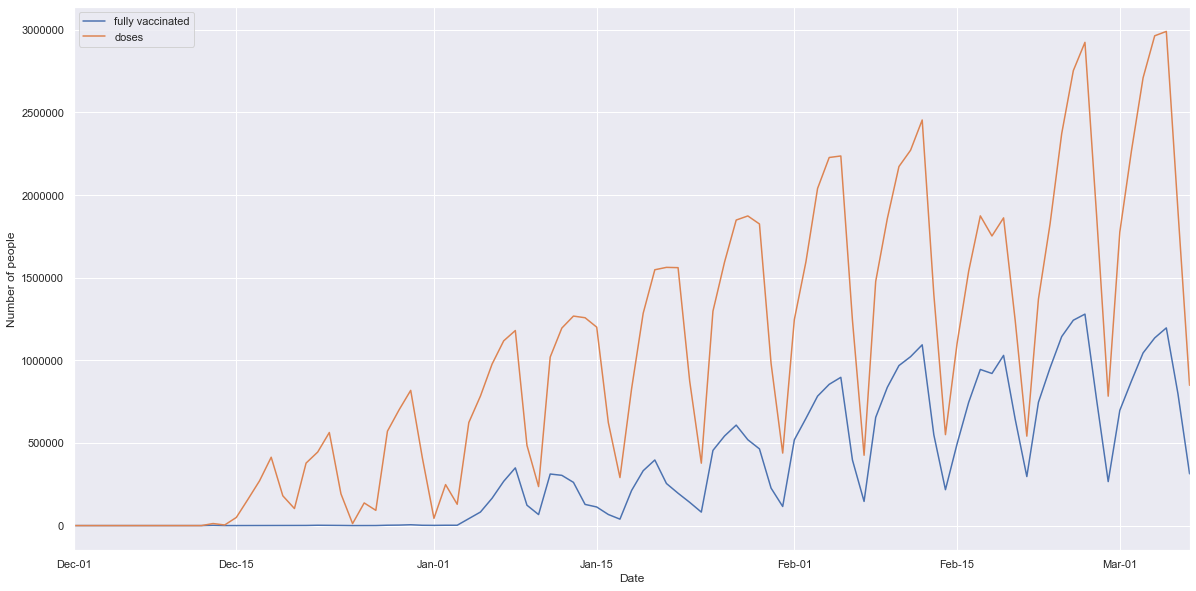

In [58]:
# ploting the x and y axis 
plt.plot(df_covid_info['Date'], df_covid_info['Daily Count of People Fully Vaccinated'], label = 'fully vaccinated')
plt.plot(df_covid_info['Date'], df_covid_info['Total Doses Administered Daily'], label = 'doses')

# format x tick labels using strptime/strftime format string
my_fmt = mdates.DateFormatter('%b-%d')
plt.gca().xaxis.set_major_formatter(my_fmt)

# produce legend with plot
plt.legend()

# resizing the plot to make it bigger
plt.gcf().set_size_inches(20,10)

# Label the graph
plt.xlabel('Date')
plt.ylabel('Number of people')

# restrict the range of the x axis
plt.xlim(['2020-12-01', '2021-03-07'])

# reformat the y axis to be in plain numbers instead of scientific notation
plt.ticklabel_format(axis='y', style='plain')

Text(0, 0.5, 'Number of people')

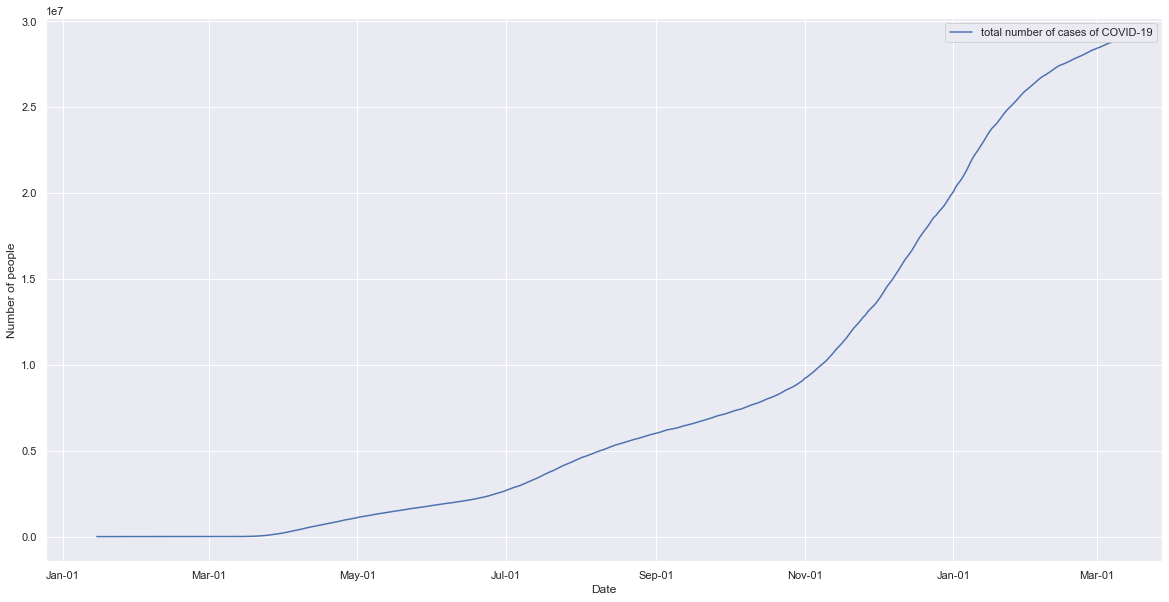

In [59]:
# ploting the x and y axis 
plt.plot(df_covid_info['Date'], df_covid_info['total cases'], label='total number of cases of COVID-19')


# format x tick labels using strptime/strftime format string
my_fmt = mdates.DateFormatter('%b-%d')
plt.gca().xaxis.set_major_formatter(my_fmt)

# produce legend with plot
plt.legend()

# resizing the plot to make it bigger
plt.gcf().set_size_inches(20,10)

# Label the graph
plt.xlabel('Date')
plt.ylabel('Number of people')

Text(0, 0.5, 'Number of people')

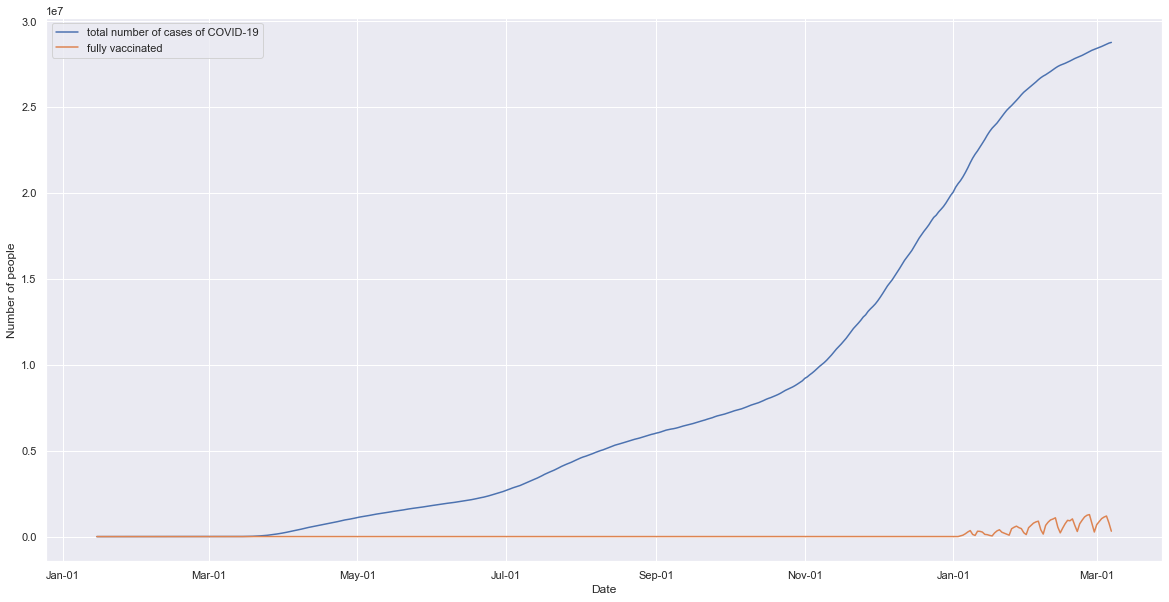

In [60]:
# ploting the x and y axis 
plt.plot(df_covid_info['Date'], df_covid_info['total cases'], label='total number of cases of COVID-19')
plt.plot(df_covid_info['Date'], df_covid_info['Daily Count of People Fully Vaccinated'], label = 'fully vaccinated')


# format x tick labels using strptime/strftime format string
my_fmt = mdates.DateFormatter('%b-%d')
plt.gca().xaxis.set_major_formatter(my_fmt)

# produce legend with plot
plt.legend()

# resizing the plot to make it bigger
plt.gcf().set_size_inches(20,10)

# Label the graph
plt.xlabel('Date')
plt.ylabel('Number of people')

## Analysis Data

Project Goal: Predicting when COVID-19 herd immunity will be reached via a combination of vaccination and infection.
- This is oservable: There is historical data for the past year demonstrating changes in case rates. There is slightly less data for vaccinations, but  we believe there will be enough to predict the trends of increasing vaccination rate. This data will help us model when infections will level off due to herd immunity.
- This is sound and simple: Historical trends in COVID case spreading are likely to mimic future COVID spread. As immunity increases (via vaccine or prior infection), the number of spreaders will decrease and so will the daily new cases. 

Our expectation is that can we get herd immunity through vaccination.
We will assume the accepted estimates for the herd immunity threshold range from 60-90% of the people.
Approach: we will estimate the percetanges of getting herd immunity by using `the number of people are vaccinated` and `people tested postive` each day.
- input will be the numeric feature (the new fully vaccinated individuals/the new positive cases) of each day.
- output will be the boolean where True when the x is over 60% and vise versa.
- the growth rate/patterns of immune individuals will need to be determined for those acquiring immunity by vaccine and by infection. 

We will use `regression` to create a function which estimates the percentage of getting herd immunity from the input. This function will show if the can get the herd immunity each day and if the output of recent dates are True -> we are likely getting the herd immunity.

## Fit a regression model to predict % fully vaccinated from date 

In [61]:
# make post_jan_df with a string index representing the date with data after Jan 1, 2021
int_df_covid = df_covid_info.reset_index(drop = False)
int_df_covid = int_df_covid.set_index('Date string')
post_jan_df = int_df_covid.loc['2021-01-01':, :]

# add a column to the dataframe that counts the days since Jan 1, 2021
days = np.empty_like(post_jan_df.loc[:, 'index'])
days.fill(1)
value = np.cumsum(days)
post_jan_df['Days since start'] = value

<ipython-input-61-9033be71e34a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_jan_df['Days since start'] = value


#### Exponential model 

Text(0, 0.5, 'Percent fully vaccinated')

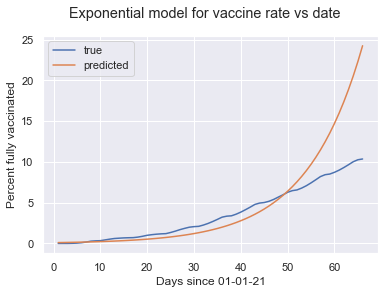

In [62]:
from sklearn.linear_model import LinearRegression

# get x (days) and y (% vaccinated)
x = np.array(post_jan_df.loc[:, 'Days since start']).reshape(-1, 1)
y = np.array(post_jan_df.loc[:, 'Percent People Fully Vaccinated'])

# train a linear regression on the log of y
reg = LinearRegression()
reg.fit(x, np.log(y))

# predict values 
y_pred = np.exp(reg.predict(x))

# plot the exponential model against the real data
plt.plot(x, y, label = 'true')
plt.plot(x, y_pred, label = 'predicted')

# groom graph
plt.legend()
plt.suptitle('Exponential model for vaccine rate vs date')
plt.xlabel('Days since 01-01-21')
plt.ylabel('Percent fully vaccinated')

#### Second degree polynomial model

Model: 0.002505929624415537x^2 + -0.004342066522861666x + 0.06036613451911028
Model: 0.0025595742715688063x^2 + -0.0073903095199827325x + 0.09203141986497582
Model: 0.0024882061496747463x^2 + -0.0033668018303845684x + 0.04364338257530936
Model: 0.002466743592778985x^2 + -0.002139069759307659x + 0.050524669055303235
Model: 0.0024884045888248166x^2 + -0.003558018077373907x + 0.05294885470932756
Model: 0.0024981467604974043x^2 + -0.004005246261014786x + 0.06057891961656574
Model: 0.002488783935944006x^2 + -0.003188817093080155x + 0.045521879253997616
Model: 0.0024877528916897383x^2 + -0.0034676390227697676x + 0.06102978193867656
Model: 0.0025168368655662833x^2 + -0.00571316790548329x + 0.07787946923562535
Model: 0.002490963040370469x^2 + -0.003961807205391647x + 0.06550454732809803


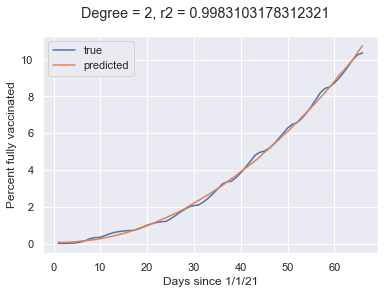

In [63]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

degree = 2

# get x (days) and y (% vaccinated)
x = np.array(post_jan_df.loc[:, 'Days since start']).reshape(-1, 1)
y = np.array(post_jan_df.loc[:, 'Percent People Fully Vaccinated'])

# fit data to a second degree polynomial structure
poly_project = PolynomialFeatures(degree=degree)
x_poly = poly_project.fit_transform(x)

# initialize a k fold and linear regression
kfold = KFold(n_splits = 10, shuffle = True)
reg = LinearRegression(fit_intercept=False)

# initialize an empty array for y_pred 
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x_poly, y): 
    # split data into train and test data
    x_poly_test = x_poly[test_idx, :]
    x_poly_train = x_poly[train_idx, :]
    y_train = y[train_idx]
        
    # fit the linear model to the training data
    reg.fit(x_poly_train, y_train)
        
    # predict y 
    y_pred[test_idx] = reg.predict(x_poly_test)
    
    # print the model 
    c = reg.coef_[0]
    b = reg.coef_[1]
    a = reg.coef_[2]
    print(f'Model: {a}x^2 + {b}x + {c}')
        
# compute the cross validated r2
r2 = r2_score(y_true=y, y_pred=y_pred)

# plot the true and predicted vaccine values
plt.plot(x, y, label = 'true')
plt.plot(x, y_pred, label = 'predicted')

# format the plot
plt.suptitle(f'Degree = 2, r2 = {r2}')
plt.xlabel('Days since 1/1/21')
plt.ylabel('Percent fully vaccinated')
plt.legend()

Text(0, 0.5, 'Percent fully vaccinated')

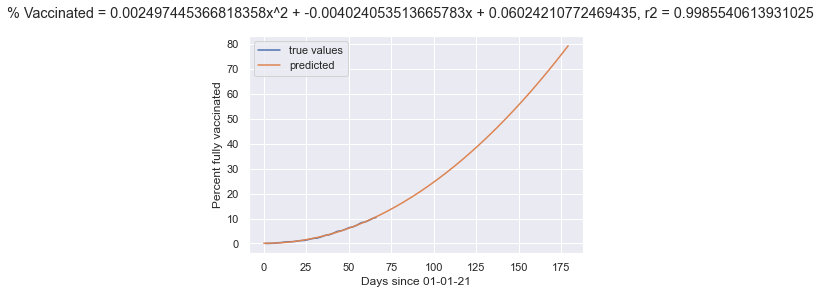

In [64]:
# compute a non-cross-validated 2nd degree model and use it to predict vaccination rates for 180 days of 2021
x_future = np.array(range(180)).reshape(-1, 1)

# fit data to 2nd degree polynomial
poly_project = PolynomialFeatures(degree=degree)
x_future_poly = poly_project.fit_transform(x_future)

# train a linear regression model on existing data and use it to predict future vaccine rates
reg = LinearRegression(fit_intercept=False)
reg.fit(x_poly, y)
y_pred = reg.predict(x_poly)
y_future_pred = reg.predict(x_future_poly)

# plot the predicted and true vaccination values 
plt.plot(x, y, label = 'true values')
plt.plot(x_future, y_future_pred, label = 'predicted')

# get the model and r2 value
c = reg.coef_[0]
b = reg.coef_[1]
a = reg.coef_[2]
r2 = r2_score(y_true=y, y_pred=y_pred)

# format plot 
plt.legend()
plt.suptitle(f'% Vaccinated = {a}x^2 + {b}x + {c}, r2 = {r2}')
plt.xlabel('Days since 01-01-21')
plt.ylabel('Percent fully vaccinated')

## Model change in daily cases over time (since testing ramped up) 

### Polynomial model 
- Look at testing data beginning 2/29/20 - the date the [FDA approved use of privately developed kits to due to faults in the CDC kit](https://www.washingtonpost.com/health/2020/02/29/new-fda-policy-will-expand-coronavirus-testing/)

In [65]:
# Only look at cases after Feb 29, 2020 - the date the FDA allowed the use of privately developed test kits 
start_date = '2020-02-29'
df_covid_cases = df_covid_info.reset_index()
df_covid_cases = df_covid_cases.set_index('Date string')
df_covid_cases = df_covid_cases.sort_index()
df_covid_cases.head()

,index,Date,Daily Count of People Fully Vaccinated,Total Doses Administered Daily,Total People Fully Vaccinated,Percent People Fully Vaccinated,tests change_from_prior_day,cases change_from_prior_day,cases population_percent,total cases
Date string,,,,,,,,,,
2020-01-15,0,2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-16,1,2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-17,2,2020-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-18,3,2020-01-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-19,4,2020-01-19,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Text(0.5, 0.98, 'R2 per degree for polynomial models')

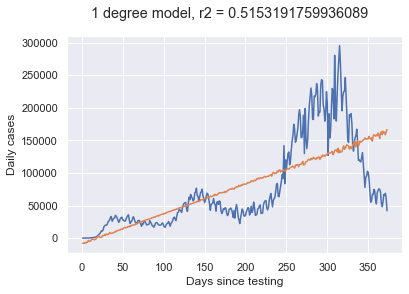

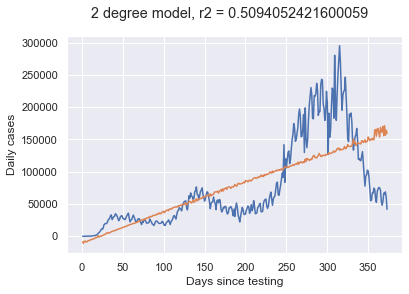

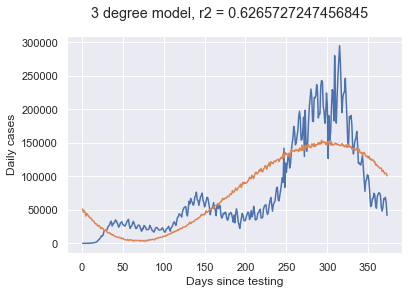

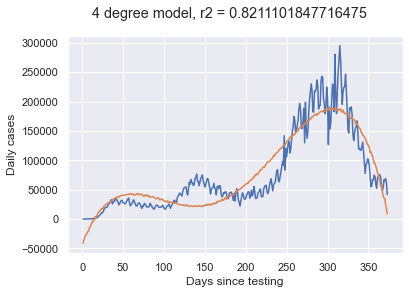

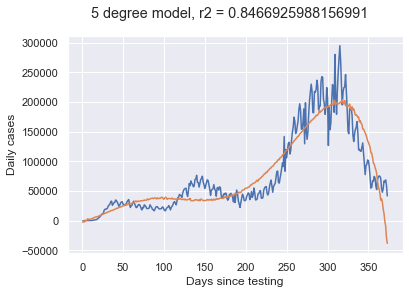

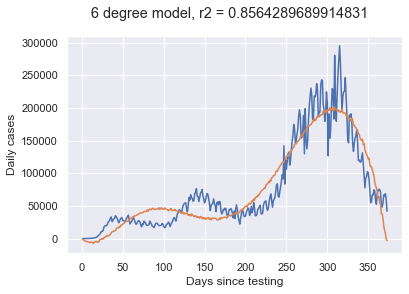

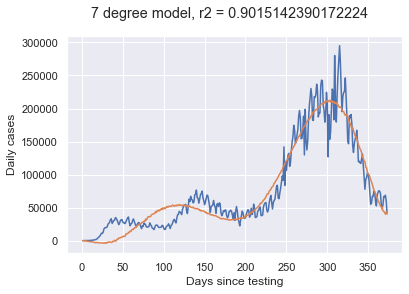

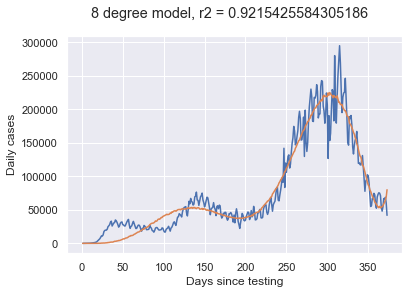

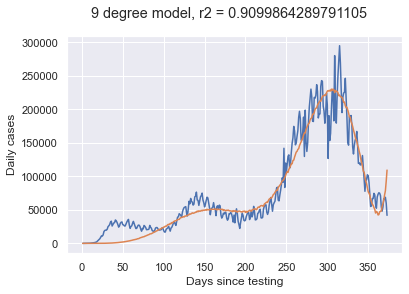

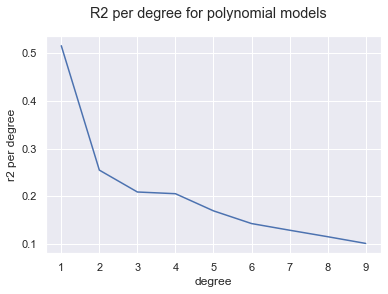

In [77]:
# Create an array counting the days since testing began ramping up (see note above)
day_ct = np.empty_like(df_covid_cases.loc[start_date:, 'Date'])
day_ct.fill(1)
day_ct = np.cumsum(day_ct)

# get data 
x = np.array(day_ct).reshape(-1, 1)
y = np.array(df_covid_cases.loc[start_date:, 'cases change_from_prior_day'])

# Test a variety of degrees for a polynomial function
degrees = range(1, 10)

# initialize a list of dicts to track r2 info 
list_r2_dict = []

for degree in degrees: 
    
    # project x to a polynomial
    poly_project = PolynomialFeatures(degree=degree)
    x_poly = poly_project.fit_transform(x)
    
    # initialize a k fold and linear regression
    kfold = KFold(n_splits = 10, shuffle = True)
    reg = LinearRegression(fit_intercept=False)

    # initialize an empty array for y_pred 
    y_pred = np.empty_like(y)
    
    # Use a k fold to cross-validate 
    for train_idx, test_idx in kfold.split(x_poly, y): 
        
        # get data 
        x_poly_test = x_poly[test_idx, :]
        x_poly_train = x_poly[train_idx, :]
        y_train = y[train_idx]
        
        # train and predict using regression
        reg.fit(x_poly_train, y_train)
        y_pred[test_idx] = reg.predict(x_poly_test)
        
    # Calculate r2 per degree 
    r2 = r2_score(y_true=y, y_pred=y_pred)
    r2_per_degree = r2/degree
    
    # track r2 data
    r2_dict = {'degree':degree, 
               'r2': r2, 
               'r2 per degree': r2_per_degree}
    list_r2_dict.append(r2_dict)
    
    # plot the predicted and real data 
    plt.plot(x, y, label = 'true')
    plt.plot(x, y_pred, label = 'predicted')
    plt.xlabel('Days since testing')
    plt.ylabel('Daily cases')
    plt.suptitle(f'{degree} degree model, r2 = {r2}')
    plt.figure()

# format r2 info as a dataframe
df_r2 = pd.DataFrame(list_r2_dict)

# graph crossvalidated r2 per degree 
plt.plot('degree', 'r2 per degree', data = df_r2)
plt.xlabel('degree')
plt.ylabel('r2 per degree')
plt.suptitle('R2 per degree for polynomial models')

## Attempt to model the relationship between daily cases (y) and % fully vaccinated (x)

In [ ]:
# Plot the relationship between % vaccinated and daily covid cases
x = post_jan_df.loc[:'2021-03-07', 'Percent People Fully Vaccinated']
y = post_jan_df.loc[:'2021-03-07', 'cases change_from_prior_day']

# plot and groom graph
plt.plot(x, y)
plt.suptitle('Daily COVID cases vs % vaccinated since Jan 2021')
plt.xlabel('% population fully vaccinated')
plt.ylabel('Daily COVID cases')

#### Second degree polynomial 
- Not a great fit because it predicts that cases will then rise again in the inverse of the decrease modeled in early 2021

In [ ]:
# try cross-validating a second degree polynomial fit to the vaccine-case data
degree = 2

# get x (% vaccinated) and y (daily cases)
x = np.array(post_jan_df.loc[:, 'Percent People Fully Vaccinated']).reshape(-1, 1)
y = np.array(post_jan_df.loc[:, 'cases change_from_prior_day'])

# fit data to a second degree polynomial structure
poly_project = PolynomialFeatures(degree=degree)
x_poly = poly_project.fit_transform(x)

# initialize a k fold and linear regression
kfold = KFold(n_splits = 10, shuffle = True)
reg = LinearRegression(fit_intercept=False)

# initialize an empty array for y_pred 
y_pred = np.empty_like(y)

for train_idx, test_idx in kfold.split(x_poly, y): 
    # split data into train and test data
    x_poly_test = x_poly[test_idx, :]
    x_poly_train = x_poly[train_idx, :]
    y_train = y[train_idx]
        
    # fit the linear model to the training data
    reg.fit(x_poly_train, y_train)
        
    # predict y 
    y_pred[test_idx] = reg.predict(x_poly_test)
    
    # print the model 
    c = reg.coef_[0]
    b = reg.coef_[1]
    a = reg.coef_[2]
    print(f'Model: {a}x^2 + {b}x + {c}')
        
# compute the cross validated r2
r2 = r2_score(y_true=y, y_pred=y_pred)

# plot the true and predicted vaccine values
plt.plot(x, y, label = 'true')
plt.plot(x, y_pred, label = 'predicted')

# format the plot
plt.suptitle(f'Degree = 2, r2 = {r2}')
plt.xlabel('Percent fully vaccinated')
plt.ylabel('Daily cases')
plt.legend()

#### Exponential model 
- Potentially a better fit; however, it predicts that cases will decrease to and remain at 0
- There's a confounding variable here - it's superspreader events like the holidays. We are only looking at the decrease from after winter holidays in this brief window of data, so % vaccines is a bad explanatory variable here 

In [ ]:
# try fitting an exponential model to the vaccine/case relationship 

# get data
x = np.array(post_jan_df.loc[:, 'Percent People Fully Vaccinated']).reshape(-1, 1)
y = np.array(post_jan_df.loc[:, 'cases change_from_prior_day'])

# train a linear regression on the log of y
reg = LinearRegression()
reg.fit(x, np.log(y))

# predict values 
y_pred = np.exp(reg.predict(x))

# plot the exponential model against the real data
plt.plot(x, y, label = 'y_true')
plt.plot(x, y_pred, label = 'y_pred')
plt.legend()

# format the plot
plt.suptitle(f'Degree = 2, r2 = {r2}')
plt.xlabel('Percent fully vaccinated')
plt.ylabel('Daily COVID cases')
plt.legend()

In [ ]:
# compute a non-cross-validated 2nd degree model relating vaccination rate to daily cases 
# and use it to predict vaccination rates for 180 days of 2021

x_future = np.array(range(50)).reshape(-1, 1)

# get data
x = np.array(post_jan_df.loc[:, 'Percent People Fully Vaccinated']).reshape(-1, 1)
y = np.array(post_jan_df.loc[:, 'cases change_from_prior_day'])

# train a linear regression on the log of y
reg = LinearRegression()
reg.fit(x, np.log(y))
y_future_pred = np.exp(reg.predict(x_future))

# plot the predicted and true vaccination values 
plt.plot(x, y, label = 'true values')
plt.plot(x_future, y_future_pred, label = 'predicted')

# get the model and r2 value
a = reg.coef_[0]

# format plot 
plt.legend()
plt.suptitle(f'Predicted daily cases based on vaccine predictions')
plt.xlabel('Days since 1/1/21')
plt.ylabel('Daily cases')